# Introduction
This code is an MCMC fit for sine curves using the emcee package (https://emcee.readthedocs.io/en/stable/). The likelihood function, priors, and random additions are set up for you already. 

### You will be changing:

1.) The initial values of the algorithm - think about how you can find these analytically based on the data that you have

2.) The number of steps the algorithm takes - think about how the number of steps you take affects the quality of your fit

3.) The generated error - think about how error changes how percice your fit can be

### A few thing to note on the items that are being plotted or printed:

1.) Trace: this shows how much your values are moving around during your fit, so how much variation you're getting. The more jagged the plot is, the more variation you get. Note the very jagged part right at the beginning, that's your burn-in. The burn-in is your MCMC figuring out what value it wants to settle on before getting into a holding pattern on that value. It is usually discarded in the next plots.

2.) Corner Plots: these show how constrained the fit is. Good corner plots should look something like this: (https://www.researchgate.net/figure/Corner-plot-resulting-from-our-MCMC-analysis-of-the-TESS-photometry-of-14-Peg-Red_fig1_347534572), where there's a good spread of values that cluster around a central point, which is our correct value. 

3.) The MCMC's Answer: these values are the answers from MCMC with errors. Our errors are calculated by getting the difference between our 50th percentile answer and our 16th percentile answer, and our 84th percentile answer and our 50th percentile answer for our lower error bar and upper error bar, respectively.

4.) Our Final Fitted Plot: note that I declare the model within the plt.plot() call itself. You might want to change this later depending on how you use this algorithm.

### Final Notes:
Values you can and should change are marked with a comment with two exclamation points. Running a 5000 step run takes about three seconds for me, it should take around that amount of time for you. Once you've gotten used to playing around with a generated fit and you've gotten used to sine fitting TOI-4468 without using MCMC, switch over to using the RV data for TOI-4468. It'll provide some interesting challenges, especially given that you will have to phase fold before you input it into the MCMC run.

A few important notes about MCMC. Depending on how your traces look, you might need to throw away more steps in your burn-in. Look for where that the line flattens out, that's how many steps you'll want to throw away. The farther away from the real values your fit is, the larger your burn-in. In MCMC, your fit will be improved the more steps you add, to a point. At a certain point, if you add more steps, you're just wasting time. Since these values have errors on them, we can only be so accurate in our knowledge of the "true value." This is just an approximation, a very good one, but still just an approximation. Keep that in mind before you ask it to run a billion steps. Finally, when you use this code for TOI-4468, I would suggest making a copy of this notebook and editing that so you still have whatever edits you've made here along with the new work you're going to do. I will always have this original copy of the notebook, so if you need it, it's always here.

Hope this is helpful, good luck, and happy fitting!

In [2]:
# Import statements - I use a lot, don't worry about these
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import emcee

import corner

from IPython.display import display, Math

import matplotlib as mpl
# mpl.rc('font', family='serif', serif='Times New Roman')
# mpl.rcParams['figure.dpi'] = 600
import seaborn as sns
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:96% !important; }</style>"))
%matplotlib inline
import glob 
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# plt.rcParams.update({'figure.figsize': (12,6)})
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.mast import Observations
import astropy.units as u
#import lightkurve as lk
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

from copy import deepcopy
from astropy import table

from astropy.io import fits

/var/folders/dk/lq6j7scd35j5b_4chx7963xr0000gp/T/ipykernel_91685/817262261.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/Users/zijunhe/Library/Python/3.9/lib/python/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==60.5.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [4]:
# Define the sine function we'll use as our model
def sin_function(t, amp, pha, vert):
    return amp * np.sin(2*np.pi * t + pha) + vert

In [5]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    amplitude, phase, vertical_shift = theta
    
    ## Check if the amplitude and frequency are greater than 0
    if amplitude > 0: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

In [6]:
# Define Likelihood Function
def log_likelihood(parameters, x, y, data_err):
    ## Get our parameters for the model
    amplitude, phase, vertical_shift = parameters
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Generate a new version of our model using our current x values
    model = sin_function(x, amplitude, phase, vertical_shift)
    
    
    ## Compare using chi squared
    chisquared = np.nansum(((y-model)**2/(data_err**2)))
    ## Return our chi squared value for later evaluation done by emcee
    return (-0.5 * chisquared)

In [7]:
# Set up initial values with random additions
ndim = 3
nwalkers = 16 # !! Change this if you want more walkers looking around parameter space. This will make your fit take longer.

# Creates an array of random additions the same size as our number of walkers and number of values being fit
random_additions = np.random.rand(nwalkers, ndim)

# Sets random additions to be a small value for a small variation
## !! Feel free to change the 0.01 values after random_additions[i][j]. I've marked them with a comment with '!!'
##  These will change how far your values change on each step of the MCMC run
for i in range(len(random_additions)):
    for j in range(len(random_additions[0])):
        if j == 0:
            random_additions[i][j] = random_additions[i][j] * 0.01 # !!
        elif j == 1:
            random_additions[i][j] = random_additions[i][j] * 0.01 # !!
        elif j == 2:
            random_additions[i][j] = random_additions[i][j] * 0.01 # !!

# Initial Values - Insert your own way to find the initial amplitude, frequency, phase, and vertical shift!
amp0 = 65 # !!
phase0 = 7 # !!
vert0 = 10 # !!

# !! Declare an array with our initial conditions
p0 = np.add(np.asarray([amp0, phase0, vert0]), random_additions)

In [8]:
# Reading and Processing of data
NEID = pd.read_csv("NEID_RVS_PRELIM (2).csv")
BM = NEID.iloc[:, 16]
avg = np.sum(BM)/8
RV = BM-avg
RV = RV*1000 #m/s
print(RV)
BJD = NEID.iloc[:, 15] #BJD(days)
print(BJD)
period_B = 2.77 #days

# Phase Folding
phase_B = (BJD % period_B) / period_B

# Error
dvrms = NEID.iloc[:, 17]
dvrms = np.random.normal(0.1, 1.0, 8) #m/s   #subtract mean of DVRMS
print(dvrms)

0   -24.1875
1   -22.7875
2     5.7125
3   -26.7875
4    13.3125
5   -25.3875
6     4.8125
7    75.3125
Name: ccfrvmod, dtype: float64
0    2.460448e+06
1    2.460412e+06
2    2.460342e+06
3    2.460329e+06
4    2.460328e+06
5    2.460240e+06
6    2.460237e+06
7    2.460195e+06
Name: ccfjdsum, dtype: float64
[0.20229691 0.02470127 0.03916594 0.19567206 0.05105661 0.09907458
 0.1377555  0.0383303 ]


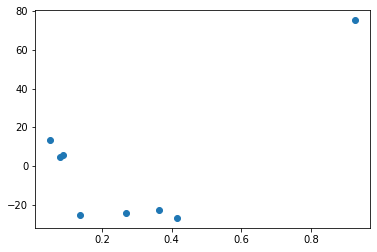

In [9]:
plt.plot(phase_B, RV, 'o')

In [10]:
# Run Emcee!
## Declare the sampler
sampler = emcee.EnsembleSampler(
    ## Tells the sampler how many walkers are wanted (nwalkers), how many values are being fitted (ndim),
    ##  our likelihood function, and the constants used in the fit/arguments (args=(t, sinecurve, gen_err)) 
    nwalkers, ndim, log_likelihood, args=(phase_B, RV, dvrms)
)
# Runs the sampler given our initial conditions (p0)
## Set to 5000 steps for a quick fit. Additionally shows a progress bar so you can see how long it will take to run
## !! Change number of steps for a more percice fit (to a point!)
sampler.run_mcmc(p0, 5000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:04<00:00, 40.14it/s]


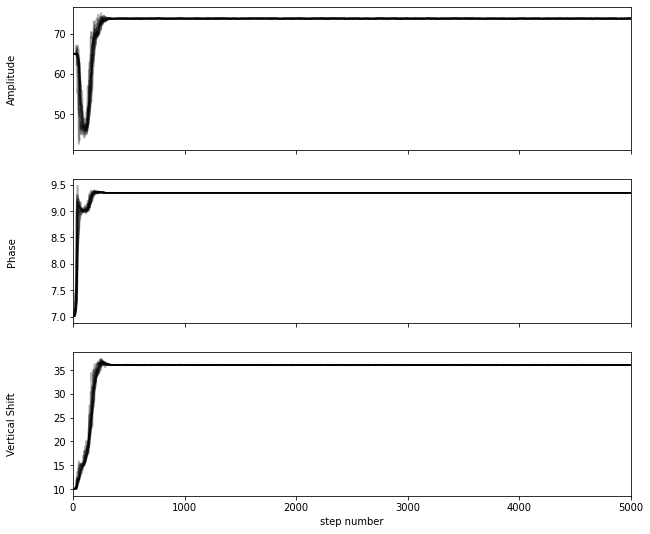

In [11]:
# Plot Trace
fig, axes = plt.subplots(ndim, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ['Amplitude', 'Phase', 'Vertical Shift']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
# Discard first 100 walkers
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True) # !! Change discard=XXX depending on how traces look
print(flat_samples.shape)

(4256, 3)


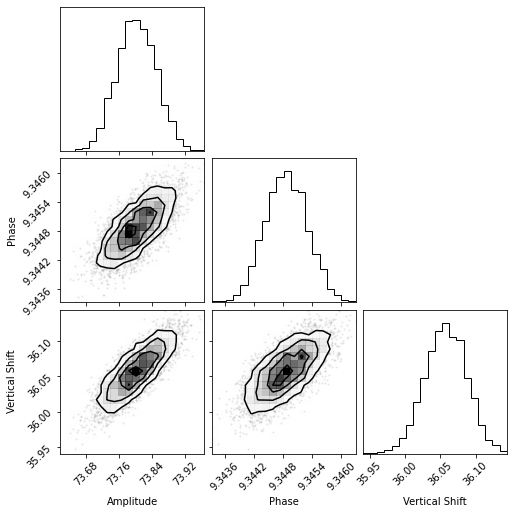

In [14]:
# Plot corner plots
fig = corner.corner(
    flat_samples, labels=labels
);

In [15]:
# Print calculated values
answers = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    answers.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
print(dvrms)

[0.20229691 0.02470127 0.03916594 0.19567206 0.05105661 0.09907458
 0.1377555  0.0383303 ]


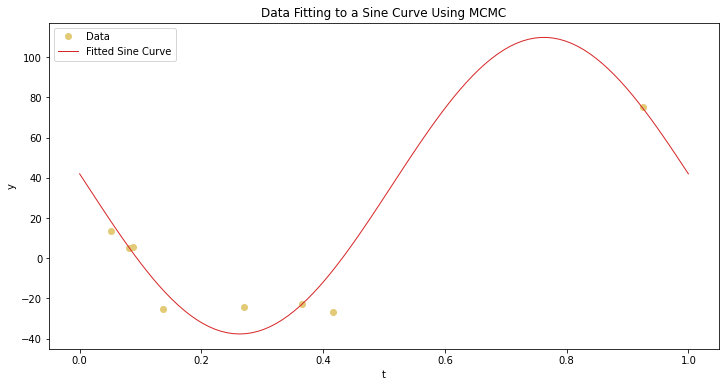

In [18]:
# Plot data and fitted curve

plt.figure(figsize=(12, 6))
plt.plot(phase_B, RV, 'o', label='Data', color='#e2ca76')
#plt.plot(phase_B, sin_function(phase_B, answers[0], answers[1], answers[2]), label='Fitted Sine Curve', color='tab:red', linewidth=3)

t = np.linspace(0,1,100)
RV_fit = sin_function(t, answers[0], answers[1], answers[2])
plt.plot(t, RV_fit, label='Fitted Sine Curve', color='tab:red', linewidth=1)

plt.xlabel('t')
plt.ylabel('y')
plt.title('Data Fitting to a Sine Curve Using MCMC')
plt.legend()

In [ ]:
# 0.822 Solar Masses